# Downloading and spliting the dataset and Creating Dataloader

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)

100%|██████████| 1.02G/1.02G [00:14<00:00, 78.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [ ]:
# Script to create train, test and validation data

import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
output_dir = 'split_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create directories for split dataset
def create_dir_structure():
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)

# Split dataset
def split_dataset():
    create_dir_structure()

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Get all image file paths in the current class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split data into train (70%), temp (30%)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)

        # Further split temp into validation (10%) and test (20%)
        val_images, test_images = train_test_split(temp_images, test_size=2/3, random_state=42)

        # Move images to respective directories
        for image in train_images:
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in val_images:
            dest_dir = os.path.join(val_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in test_images:
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

# Run the script
if __name__ == '__main__':
    split_dataset()
    print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.transforms.functional as F
import timm
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "split_dataset"


In [ ]:
# Model name
model_name = "vit_base_patch16_224"

In [ ]:
# Number of classes
num_classes = 10

# Batch size
batch_size = 16

# Number of epochs
num_epochs = 30

# Flag for feature extracting
feature_extract = False

In [ ]:

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model Initializing and Training

In [ ]:
# Initialize the model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "vit_base_patch16_224":
        model_ft = timm.create_model('vit_base_patch16_224', pretrained=use_pretrained, num_classes=num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Set parameter requires grad
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
set_parameter_requires_grad(model_ft, feature_extract)

In [ ]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training the model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
# # Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 1.1286 Acc: 0.6196
val Loss: 0.8964 Acc: 0.6913
Epoch 1/29
----------
train Loss: 0.7875 Acc: 0.7337
val Loss: 0.4523 Acc: 0.8538
Epoch 2/29
----------
train Loss: 0.5565 Acc: 0.8155
val Loss: 0.3499 Acc: 0.8875
Epoch 3/29
----------
train Loss: 0.4517 Acc: 0.8511
val Loss: 0.3388 Acc: 0.8913
Epoch 4/29
----------
train Loss: 0.4061 Acc: 0.8668
val Loss: 0.2708 Acc: 0.9183
Epoch 5/29
----------
train Loss: 0.3433 Acc: 0.8850
val Loss: 0.2715 Acc: 0.9202
Epoch 6/29
----------
train Loss: 0.3114 Acc: 0.8988
val Loss: 0.2458 Acc: 0.9260
Epoch 7/29
----------
train Loss: 0.2574 Acc: 0.9144
val Loss: 0.2190 Acc: 0.9413
Epoch 8/29
----------
train Loss: 0.2412 Acc: 0.9180
val Loss: 0.2150 Acc: 0.9423
Epoch 9/29
----------
train Loss: 0.2188 Acc: 0.9255
val Loss: 0.1786 Acc: 0.9490
Epoch 10/29
----------
train Loss: 0.2029 Acc: 0.9339
val Loss: 0.1653 Acc: 0.9462
Epoch 11/29
----------
train Loss: 0.1901 Acc: 0.9352
val Loss: 0.1387 Acc: 0.9587
Epoch 12/29
--

In [ ]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'nn-vt-org-weights.pth')


In [ ]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.show()

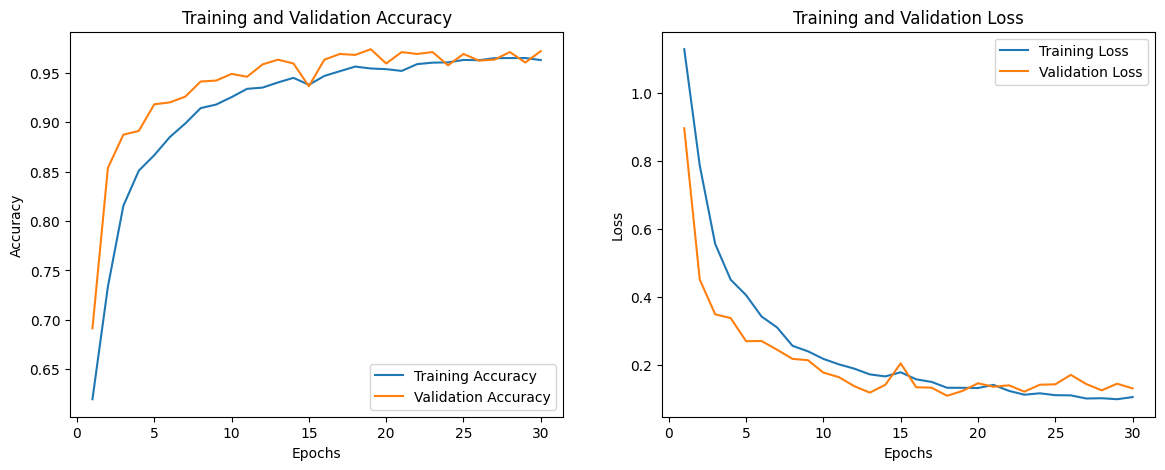

In [ ]:
# Call the plot function
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)


## Model Testing

In [ ]:
# Evaluate the model on test data
model_ft.eval()
model_ft=model_ft.to(device)
test_corrects = 0
all_preds = []
all_labels = []
# device="cpu"
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))


Test Accuracy: 0.9602


In [ ]:
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [ ]:
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[ 88   0   0   0   4   0   1   3   0   0]
 [  1  73   0   0   1   0   1   0   0   0]
 [  0   0  60   2   0   4   0   0   1   1]
 [  0   0   0 333   0   0   5   3   3   4]
 [  0   1   0   3 178   0   3   3   4   2]
 [  0   0   0   0   0 289   0   0   0   0]
 [  0   0   0   3   0   0 112   4   2   3]
 [  0   0   0   2   0   0   0 312   5   1]
 [  0   0   0   1   0   0   0   4 349   0]
 [  0   0   0   3   0   0   1   4   0 210]]
Classification Report:
                           precision    recall  f1-score   support

   bacterial_leaf_blight       0.99      0.92      0.95        96
   bacterial_leaf_streak       0.99      0.96      0.97        76
bacterial_panicle_blight       1.00      0.88      0.94        68
                   blast       0.96      0.96      0.96       348
              brown_spot       0.97      0.92      0.94       194
              dead_heart       0.99      1.00      0.99       289
            downy_mildew       0.91      0.90      0.91       1

In [ ]:
# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('cura_vt_results.csv', index=False)

                     actual              predicted
0     bacterial_leaf_blight  bacterial_leaf_blight
1                brown_spot             brown_spot
2                     blast                  blast
3                     hispa                  hispa
4                     blast                 tungro
...                     ...                    ...
2082                  hispa                  hispa
2083                 normal                 normal
2084                  blast                  blast
2085  bacterial_leaf_streak  bacterial_leaf_streak
2086                 tungro           downy_mildew

[2087 rows x 2 columns]


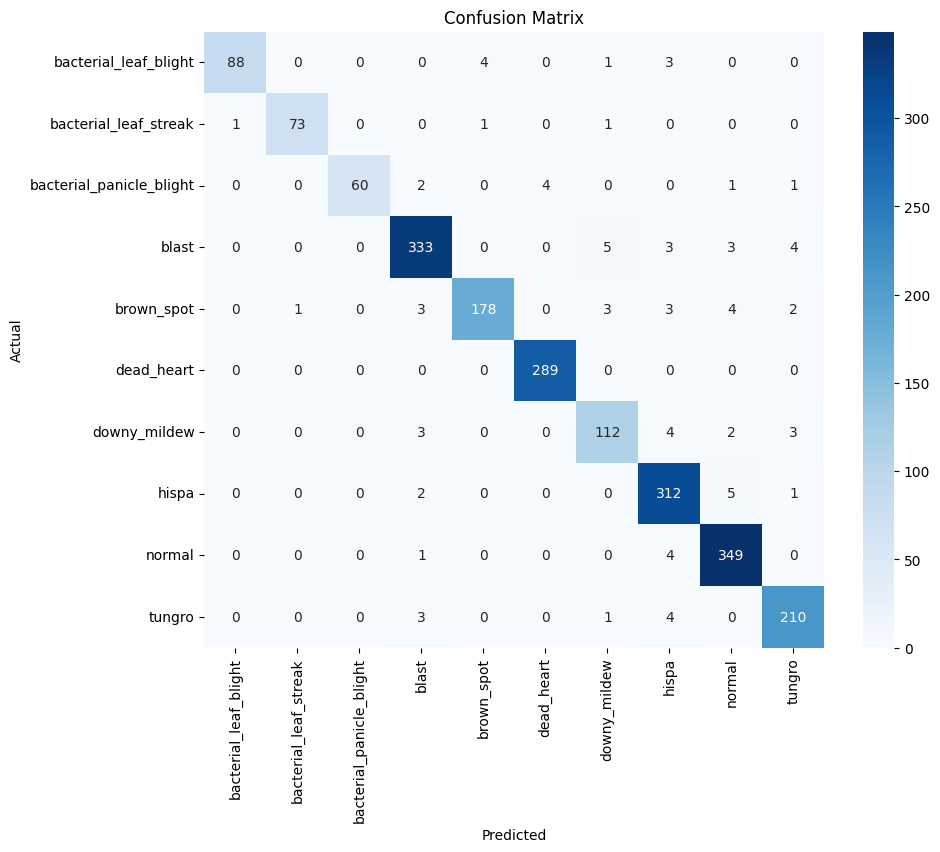

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('curat_vt_confusion_matrix.png')
plt.show()


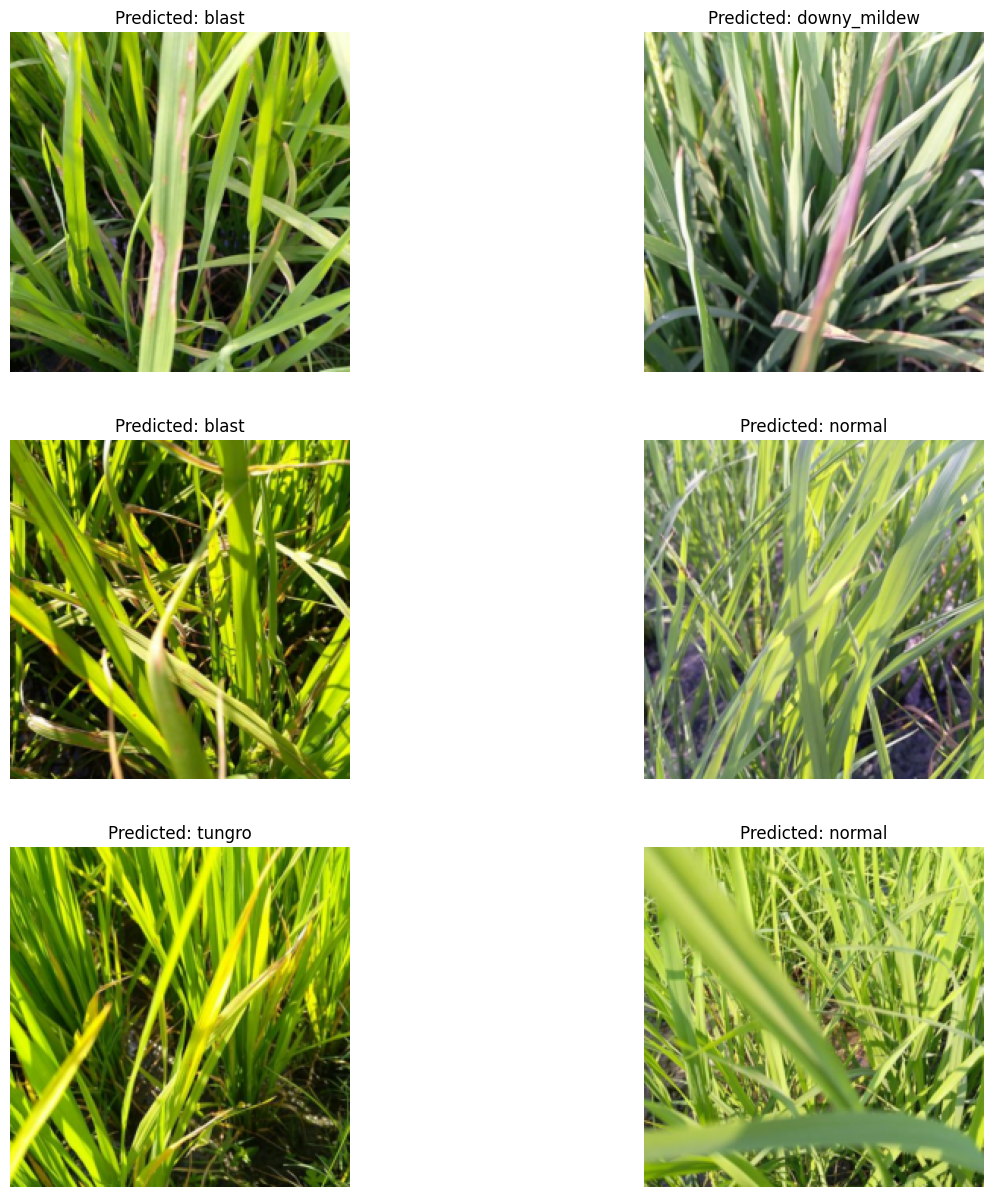

In [ ]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

# Function to visualize predictions
def visualize_predictions(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model=model.to(device)
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')
                # plt.imshow(F.to_pil_image(inputs.cpu().data[j]))
                img = inputs.cpu().data[j]
                img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                plt.imshow(F.to_pil_image(img.clamp(0, 1)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

# Visualize predictions
visualize_predictions(model_ft, dataloaders, class_names, num_images=6)

In [ ]:
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")

# Ensure the confusion matrix and the classification report are saved
with open('curat_vt_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")

Accuracy: 0.9602
Average Precision: 0.9650
Average Recall: 0.9461
Average F1-Score: 0.9549


In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)


In [ ]:
model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))

<ipython-input-29-3cbf5701cf52>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('nn-vt-org-weights.pth'))


<All keys matched successfully>

In [ ]:
print(inputs.device)

cuda:0
